## Decision Tree Demo

This is an implementation of a decision tree learning algorithm inspired by the Classification and Regression Tree (CART) algorithm. There is for sure some previous knowledge given my usage of TMVA and scikit-learn, so this is more an exploration for fun than something novel and highly optimized by the authors of those packages and their communities. In course of researching this topic, I consulted the following references:

- Wikipedia ([Decision tree learning](https://en.wikipedia.org/wiki/Decision_tree_learning))
- Jason Brownlee's [blog post](https://machinelearningmastery.com/implement-decision-tree-algorithm-scratch-python/) on implementing a decision tree algorithm
- Gilles Louppe's [PhD Thesis](https://orbi.uliege.be/bitstream/2268/170309/1/thesis.pdf)
- scikit-learn's [documentation](https://scikit-learn.org/stable/modules/tree.html) on decision trees

In [1]:
from collections import namedtuple
from uuid import uuid4

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs, make_circles, make_moons

%matplotlib inline

# Set the random state for reproducibility.
np.random.seed(42)

### 1. Gini Impurity
---

The Gini impurity measures how often a random element in a set of examples would be incorrectly labelled if it was randomly assigned a label based on the distribution of class labels in the set. It is used by the CART algorithm to split the dataset into disjoint subsets at each node. In more formal terms, suppose there are $K$ class labels in the set, $p_{i}$ is the probability of choosing an example with label $i$, and the probability of incorrectly labelling the chosen example with label $i$ is

$$\sum_{k \neq i} p_{k} = 1 - p_{i}.$$

Then the Gini impurity may be defined as

$$
I_{G}(p) = \sum_{i = 1}^{K} p_{i} \sum_{k \neq i} p_{k}
         = \sum_{i = 1}^{K} p_{i} (1 - p_{i})
         = \sum_{i = 1}^{K} (p_{i} - p_{i}^{2})
         = \sum_{i = 1}^{K} p_{i} - \sum_{i = 1}^{K} p_{i}^{2}
         = 1 - \sum_{i = 1}^{K} p_{i}^{2}
$$

This measure is used to inform the design of the tree, specifically in how each node decides to split its subset of the dataset into disjoint subsets.

In [2]:
def gini_impurity(y):
    """Compute the Gini impurity of a set of class labels.
    
    Parameters
    ----------
    y : np.ndarray
        An integer array of class labels.
    """
    _, unique_counts = np.unique(y, return_counts=True)
    p_labels = unique_counts / y.size
    return 1 - np.sum(p_labels**2)

If there is only one class label for all examples in a set, then the Gini impurity is zero because there is no chance to incorrectly label a randomly sampled example, i.e. the set is pure. In the worst case, there are as many unique class labels are there are examples in a set, thus maximizing the Gini impurity. Let's corroborate that our function reflects those properties.

In [3]:
best_case = np.ones(shape=(10,), dtype=np.int64)
middle_case = np.random.choice([0, 1],size=(10,))
worst_case = np.arange(0, 10)

for test_case in [best_case, middle_case, worst_case]:
    print(f'The Gini impurity of the set of labels {test_case} is {gini_impurity(test_case):.2f}.')

The Gini impurity of the set of labels [1 1 1 1 1 1 1 1 1 1] is 0.00.
The Gini impurity of the set of labels [0 1 0 0 0 1 0 0 0 1] is 0.42.
The Gini impurity of the set of labels [0 1 2 3 4 5 6 7 8 9] is 0.90.


### 2. Deciding How to Split the Data
---

Suppose that examples in the dataset are of the form $(\vec{x}, y) = \{(x_{1}, x_{2}, \ldots, x_{n}), y\}$, where $\vec{x}$ is the vector of $n$ input features for an example, and which follows a consistent ordering scheme, and $y$ is the class label of an example. Then the dataset is amenable to being expressed as an array of input features $X_{m \times n}$ whose shape is determined by the number of examples $m$ and the number of input features $n$ and an array of class labels $y_{m \times 1}$. By using NumPy arrays, our implementation can benefit from NumPy's vectorized operations.

The optimal split at each step of building the tree is the one that locally minimizes the Gini impurity. To find it, all possible ways to split the dataset along a single input feature are first evaluated and the best resulting split chosen. The best possible split out over all the input features is then chosen to be the optimal split.

In [4]:
Split = namedtuple('Split', ['feature', 'value', 'impurity_before', 'impurity_after', 'num_samples'])


def find_best_split(X, y):
    """Find the split that minimizes the Gini impurity of a dataset.
    
    Parameters
    ----------
    X : np.ndarray
        The array of input feature vectors of shape (m, n), where m
        is the number of examples and n is the number of input features.
    y : np.ndarray
        The array of class labels of shape (m, 1), where m is the
        number of examples.
    
    Returns
    -------
    best_split : Split
        A namedtuple whose fields describe the following
        properties of the best split:
        - feature
          The index of the feature in the input feature vector.
        - value
          The value of the input feature to split on.
        - impurity_before
          The Gini impurity of the dataset before the split.
        - impurity_after
          The Gini impurity of the dataset after the split.
        - num_samples
          The total number of samples in the dataset to split.
    """
    # For each input feature, evaluate the best possible split.
    split_candidates = []
    for i, feature in enumerate(X.T):
        # Sort the i-th input feature and class labels
        # in ascending order of the feature values.
        indices = np.argsort(feature, kind='mergesort')
        feature_sorted, y_sorted = feature[indices], y[indices]
        
        # Compute the impurity after splitting for all possible splits.
        impurity_after = [
            gini_impurity(y_sorted[:split]) + gini_impurity(y_sorted[split:])
            for split in np.arange(1, len(y_sorted))
        ]
        
        # Find the index corresponding to the minimum impurity after splitting.
        split_index = np.argmin(impurity_after)
        
        # Calculate the value used to split the dataset along the i-th input feature
        # as the mid-point of the two values surrounding the proposed split.
        split_value = (feature_sorted[split_index] + feature_sorted[split_index + 1]) / 2
        
        # Add a tuple to the list of candidate splits.
        split_candidates.append(Split(i, split_value, gini_impurity(y), impurity_after[split_index], len(y)))

    # Choose the best possible split over all input features
    # based on the local minimum of the impurity after split.
    best_split = sorted(split_candidates, key=lambda split: split.impurity_after)[0]

    # Return the best split only if it decreased the Gini impurity.
    if best_split.impurity_after < best_split.impurity_before:
        return best_split
    else:
        return None

### 3. Representing a Binary Decision
---

Given our choice of data representation, we can think about how we want to represent the fundamental unit of a decision tree: the individual nodes. The root and internal nodes need a way to represent their decision, which means keeping track of which feature was used by the node to split the data it encounters and the value that defines the split. The decisions made at the leaf nodes which output a class label also need to be tracked. Some additional metadata and quality of life attributes will make debugging and logging easier as well.

In [5]:
class Node(object):
    """A binary decision tree node.

    Parameters
    ----------
    id : string, optional
        An optional unique ID for the node.
    """
    def __init__(self, id=None):
        self.id = id or uuid4().hex
        # Initialize members for the split and child nodes.
        self.split = None
        self.parent = None
        self.left = None
        self.right = None

    def predict(self, X):
        """Make predictions for a batch of examples.

        Parameters
        ----------
        X : np.ndarray
            The array of input feature vectors of shape (m, n), where m
            is the number of examples and n is the number of input features.

        Returns
        -------
        y_pred : np.ndarray
            The array of predictions.
        """
        y_pred = np.full(shape=(X.shape[0], 1), fill_value=-99, dtype=np.int64)
        to_left = X[:, self.split.feature] < self.split.value
        if isinstance(self.left, Node):
            y_pred[to_left] = self.left.predict(X[to_left])
        else:
            y_pred[to_left] = self.left
        if isinstance(self.right, Node):
            y_pred[~to_left] = self.right.predict(X[~to_left])
        else:
            y_pred[~to_left] = self.right
        return y_pred

    def __repr__(self):
        return f'<{self.__class__.__name__} {self.id}>'

    def __str__(self):
        """Print the decision of the node."""
        left_message = f'GOTO {self.left!r}' if isinstance(self.left, Node) else f'PREDICT {self.left:d}'
        right_message = f'GOTO {self.right!r}' if isinstance(self.right, Node) else f'PREDICT {self.right:d}'
        return f'{self!r} => {left_message} IF (FEATURE {self.split.feature:d} < {self.split.value:.3f}) ELSE {right_message}'

### 4. Building a Decision Tree
---

The decision tree object will need a method to build itself starting from a root node as well as members which represent any stop conditions, such as:

- `max_depth`  
  The maximum depth of the decision tree, or the maximum number of edges between the root node and a leaf node. This is an important hyperparameter used to prevent overfitting, as an unlimited number of decisions will start capturing structures specific to the training dataset that aren't general.
- `min_samples_split`  
  The minimum number of samples required to consider forming a split. A dataset that could be sensibly split would have to consist of at least two samples, but the tradeoff is again potential overfitting because this constraint could allow leaf nodes to make a prediction based on a single example. By increasing the value of this hyperparameter, the leaf nodes are required to form their prediction by considering multiple samples.




In [6]:
def majority_class(y):
    """Find the majority class represented by a set of class labels.

    Parameters
    ----------
    y : np.ndarray
        An integer array of class labels.

    Returns
    -------
    int
        The class label of the majority class.
    """
    unique, unique_counts = np.unique(y, return_counts=True)
    return unique[np.argmax(unique_counts)]


class DecisionTree(object):
    """A binary decision tree inspired by the CART algorithm.

    Parameters
    ----------
    max_depth : int, optional
        The maximum depth of the decision tree, or the maximum
        number of edges between the root node and a leaf node.
        By default, there are no restrictions on the depth.
    min_samples_split : int, optional
        The minimum number of samples required to consider splitting
        a node. By default, there must be at least two samples to
        perform a split.
    """
    def __init__(self, max_depth=None, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.num_nodes = 0
        self.num_leaves = 0
        self.root = None

    def fit(self, X, y, tolerance=0.005, verbose=False):
        """Build the decision tree by minimizing the Gini impurity.

        Parameters
        ----------
        X : np.ndarray
            The array of input feature vectors of shape (m, n), where m
            is the number of examples and n is the number of input features.
        y : np.ndarray
            The array of class labels of shape (m, 1), where m is the
            number of examples.
        tolerance : float, optional
            The required tolerance for the decrease in Gini impurity
            in order for a split to be considered useful. The default
            value is 0.01.
        verbose : bool, optional
            A flag to enable verbose logging during the fitting process.
            The default is False for no logging statements.
        """
        self.num_nodes += 1
        self.root = Node(id=self.num_nodes)
        self.split(self.root, X, y, tolerance=tolerance, verbose=verbose)

    def split(self, node, X, y, depth=0, tolerance=0.005, verbose=False):
        """Recursively split a node.
        
        Parameters
        ----------
        node : Node
            The current node to split.
        X : np.ndarray
            The array of input feature vectors of shape (m, n), where m
            is the number of examples and n is the number of input features.
        y : np.ndarray
            The array of class labels of shape (m, 1), where m is the
            number of examples.
        depth : int, optional
            The depth of the current node. This is automatically
            tracked and used only is a maximum depth is specified.
        tolerance : float, optional
            The required tolerance for the decrease in Gini impurity
            in order for a split to be considered useful. The default
            value is 0.01.
        verbose : bool, optional
            A flag to enable verbose logging during the fitting process.
            The default is False for no logging statements.
        """
        # There aren't enough samples to perform a split.
        if len(X) < self.min_samples_split:
            if verbose:
                print(f'[{node!r}] Not enough samples to perform a split')
            if node.parent.left is node:
                node.parent.left = majority_class(y)
            else:
                node.parent.right = majority_class(y)
            return
        
        # Assign the best split to the node.
        if verbose:
            print(f'[{node!r}] Determining best split...')
        node.split = find_best_split(X, y)

        # If there isn't a best split because any possible split only increases
        # the Gini impurity, reduce the current node into an effective leaf node.
        if node.split is None:
            if verbose:
                print(f'[{node!r}] No splits were found to reduce the Gini impurity')
            self.num_nodes -= 1
            self.num_leaves += 1
            if node.parent.left is node:
                node.parent.left = majority_class(y)
            else:
                node.parent.right = majority_class(y)
            return
        elif verbose:
            print(f'[{node!r}] Best split found to be {node.split}')

        # If the decrease in Gini impurity is not sufficient,
        # reduce the current node into an effective leaf node.
        impurity_difference = node.split.impurity_before - node.split.impurity_after
        if impurity_difference < tolerance:
            if verbose:
                print(f'[{node!r}] The decrease in Gini impurity failed the required tolerance of {tolerance:.2f}')
            self.num_nodes -= 1
            self.num_leaves += 1
            if node.parent.left is node:
                node.parent.left = majority_class(y)
            else:
                node.parent.right = majority_class(y)
            return

        # Split the dataset according to the best split.
        to_left = X[:, node.split.feature] < node.split.value
        X_left, y_left = X[to_left], y[to_left]
        X_right, y_right = X[~to_left], y[~to_left]

        # If only one class label remains in the left dataset, assign a leaf
        # node which predicts that class. Otherwise, check if there are enough
        # samples in the left dataset to perform a split. If there are, assign
        # a child node in the case when the maximum depth will not be exceeded.
        # Otherwise, assign a leaf node that predicts the majority class.
        if (y_left == y_left[0]).all():
            if verbose:
                print(f'[{node!r}] Only one class remains in the left branch, predict {y_left[0]:d}')
            self.num_leaves += 1
            node.left = y_left[0]
        elif len(X_left) >= self.min_samples_split:
            if (self.max_depth is None) or (depth < self.max_depth):
                self.num_nodes += 1
                node.left = Node(id=self.num_nodes)
                node.left.parent = node
                if verbose:
                    print(f'[{node!r}] Continuing to split down the left branch to {node.left!r}')
                self.split(node.left, X_left, y_left, depth=depth + 1, tolerance=tolerance, verbose=verbose)
            else:
                self.num_leaves += 1
                node.left = majority_class(y_left)
                if verbose:
                    print(f'[{node!r}] Splitting down the left branch would exceed the maximum depth, predict {node.left:d}')

        # Apply the same logic to the right dataset as the left dataset.
        if (y_right == y_right[0]).all():
            if verbose:
                print(f'[{node!r}] Only one class remains in the right branch, predict {y_right[0]:d}')
            self.num_leaves += 1
            node.right = y_right[0]
        elif len(X_right) >= self.min_samples_split:
            if (self.max_depth is None) or (depth < self.max_depth):
                self.num_nodes += 1
                node.right = Node(id=self.num_nodes)
                node.right.parent = node
                if verbose:
                    print(f'[{node!r}] Continuing to split down the right branch to {node.right!r}')
                self.split(node.right, X_right, y_right, depth=depth + 1, tolerance=tolerance, verbose=verbose)
            else:
                self.num_leaves += 1
                node.right = majority_class(y_right)
                if verbose:
                    print(f'[{node!r}] Splitting down the right branch would exceed the maximum depth, predict {node.right:d}')

    def predict(self, X):
        """Make predictions for a batch of examples.

        Parameters
        ----------
        X : np.ndarray
            The array of input feature vectors of shape (m, n), where m
            is the number of examples and n is the number of input features.

        Returns
        -------
        y_pred : np.ndarray
            The array of predictions.
        """
        return self.root.predict(X)
    
    @staticmethod
    def print_node(node):
        """Recursively print a node and its children."""
        print(node)
        if isinstance(node.left, Node):
            DecisionTree.print_node(node.left)
        if isinstance(node.right, Node):
            DecisionTree.print_node(node.right)
    
    def print(self):
        """Print some information about the decision tree and its decisions."""
        print(f'Decision Tree with {self.num_nodes} node(s) and {self.num_leaves} leaves.')
        self.print_node(self.root)

### 5. Super Easy Linearly Separable Test Case
---

Let's try out our decision tree on a stupidly simple test case with two classes that are linearly separable.

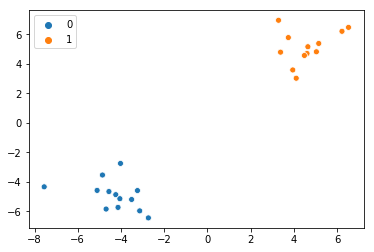

In [7]:
X, y = make_blobs(
    n_samples=25,
    n_features=2,
    centers=[[-5, -5], [5, 5]],
    random_state=0,
)

sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y);

Let's turn on logging during training to follow what's happening.

In [8]:
tree = DecisionTree()
tree.fit(X, y, verbose=True)
tree.print()

[<Node 1>] Determining best split...
[<Node 1>] Best split found to be Split(feature=0, value=0.2817422166812975, impurity_before=0.4992, impurity_after=0.0, num_samples=25)
[<Node 1>] Only one class remains in the left branch, predict 0
[<Node 1>] Only one class remains in the right branch, predict 1
Decision Tree with 1 node(s) and 2 leaves.
<Node 1> => PREDICT 0 IF (FEATURE 0 < 0.282) ELSE PREDICT 1


Okay, it looks like it worked. Let's see its predictions on previously unseen points.

In [9]:
# Make predictions in each of the four quadrants.
quadrant_centers = np.array([[1, 1], [-1, 1], [-1, -1], [1, -1]])
tree.predict(quadrant_centers)

array([[1],
       [0],
       [0],
       [1]])

The decision tree decided to split the space along the first feature, or the horizontal dimension, such that everything to the left of the decision boundary is predicted to be class 0 and everything to the right of the decision boundary is predicted to be class 1. It could just have easily done so along the vertical dimension, but either split would reduce the Gini impurity to zero so it chose just one and stopped when it needed to. Let's get a visual representation of the decision for some more insight.

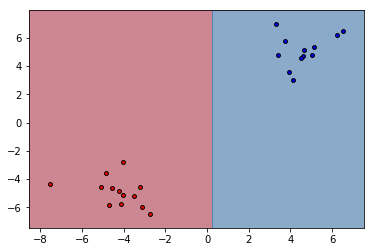

In [10]:
def plot_decision_boundaries(tree, X, y, plot_step=0.02, alpha=0.5):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step))
    Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot the decision.
    fig, ax = plt.subplots()
    plt.contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=alpha)

    # Plot the data.
    idx0 = np.where(y == 0)
    plt.scatter(X[idx0, 0], X[idx0, 1], c='r', label='Class 0', cmap=plt.cm.RdBu, edgecolor='black', s=15)
    idx1 = np.where(y == 1)
    plt.scatter(X[idx1, 0], X[idx1, 1], c='b', label='Class 1', cmap=plt.cm.RdBu, edgecolor='black', s=15)

    plt.show()

plot_decision_boundaries(tree, X, y)

### 6. Slightly Harder Linearly Separable Test Case
---

What if we modify the test case above such that the horizontal spread of the underlying distribution for class 1 is increased and sits closer to that of class 0?

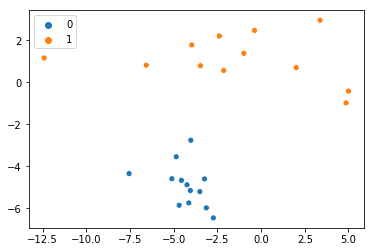

In [11]:
X, y = make_blobs(
    n_samples=25,
    n_features=2,
    centers=[[-5, -5], [1, 1]],
    random_state=0,
)

# Smear the horizontal position of class 1 examples using a Gaussian.
is_class_1 = (y == 1)
X[:, 0][is_class_1] += np.random.normal(scale=5, size=is_class_1.sum())

sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y);

In [12]:
tree = DecisionTree()
tree.fit(X, y)
tree.print()

Decision Tree with 1 node(s) and 2 leaves.
<Node 1> => PREDICT 0 IF (FEATURE 1 < -1.870) ELSE PREDICT 1


And let's do some predictions for the same points as before.

In [13]:
# Make predictions in each of the four quadrants.
quadrant_centers = np.array([[1, 1], [-1, 1], [-1, -1], [1, -1]])
tree.predict(quadrant_centers)

array([[1],
       [1],
       [1],
       [1]])

Great, so this time the decision tree decided to split the space along the second feature, or the vertical dimension, such that everything below the decision boundary is predicted to be class 0 and everything above the decision boundary is predicted to be class 1. Our points are all predicted to be class one because they all lie above the decision boundary, i.e. the value of the second feature is greater than -1.870.

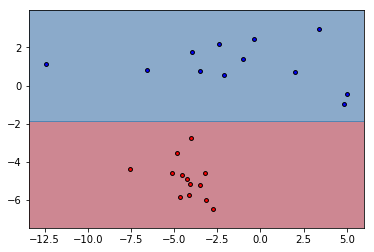

In [14]:
plot_decision_boundaries(tree, X, y)

### 7. The First Linearly Inseparable Test Case
---

Now onto something more interesting. If we allow the two classes to have some overlap, we should get samples which are confusing to classify. Let's see if the decision tree can handle it. As before, we'll fit a decision tree and make some predictions.

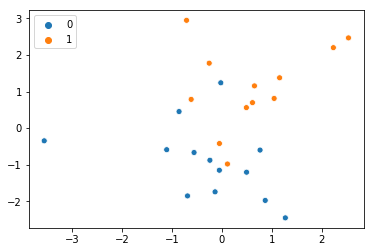

In [15]:
X, y = make_blobs(
    n_samples=25,
    n_features=2,
    centers=[[-1, -1], [1, 1]],
    random_state=0,
)

sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y);

In [16]:
tree = DecisionTree()
tree.fit(X, y)
tree.print()

# Make predictions in each of the four quadrants.
quadrant_centers = np.array([[1, 1], [-1, 1], [-1, -1], [1, -1]])
tree.predict(quadrant_centers)

Decision Tree with 1 node(s) and 2 leaves.
<Node 1> => PREDICT 0 IF (FEATURE 1 < 0.508) ELSE PREDICT 1


array([[1],
       [1],
       [0],
       [0]])

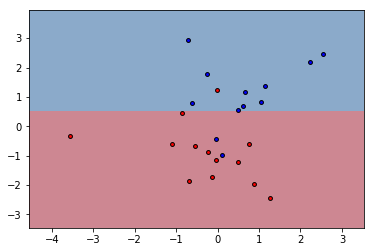

In [17]:
plot_decision_boundaries(tree, X, y)

It looks like the decision tree did a decent job. I think it can be attributed to the tolerance required on the decrease in Gini impurity for a split to be considered. Is that the case? Since the algorithm is deterministic, we should be able to catch what happened if we train another decision tree with logging enabled.

In [18]:
tree = DecisionTree()
tree.fit(X, y, verbose=True)

[<Node 1>] Determining best split...
[<Node 1>] Best split found to be Split(feature=1, value=0.5080996026758944, impurity_before=0.4992, impurity_after=0.41018721538202074, num_samples=25)
[<Node 1>] Continuing to split down the left branch to <Node 2>
[<Node 2>] Determining best split...
[<Node 2>] No splits were found to reduce the Gini impurity
[<Node 1>] Continuing to split down the right branch to <Node 2>
[<Node 2>] Determining best split...
[<Node 2>] No splits were found to reduce the Gini impurity


Okay, so that wasn't the case. What happened instead was that none of the possible splits were able to reduce the Gini impurity, or as I understand it the best splitting that achieved the lowest Gini impurity out of all possible splits still led the a Gini impurity that was equal to or greater than the Gini impurity before splitting. Because nothing of value is gained from such a split, that decision is terminated with a leaf node.

### 8. The First Linearly Inseparable Test Case Redux
---

How stable were the choices of our decision tree in our previous example if we try running it with a larger dataset?

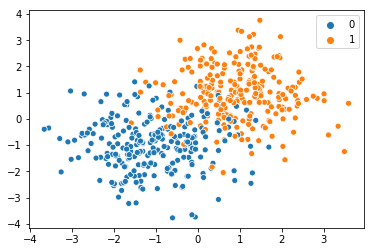

In [19]:
X, y = make_blobs(
    n_samples=500,
    n_features=2,
    centers=[[-1, -1], [1, 1]],
    random_state=0,
)

sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y);

Let's keep it to verbose to catch any new action.

In [20]:
tree = DecisionTree()
tree.fit(X, y, verbose=True)
tree.print()

[<Node 1>] Determining best split...
[<Node 1>] Best split found to be Split(feature=0, value=-0.041277342183270116, impurity_before=0.5, impurity_after=0.46991423221695494, num_samples=500)
[<Node 1>] Continuing to split down the left branch to <Node 2>
[<Node 2>] Determining best split...
[<Node 2>] Best split found to be Split(feature=1, value=1.414886250287792, impurity_before=0.23071670135275757, impurity_after=0.18663194444444442, num_samples=248)
[<Node 2>] Continuing to split down the left branch to <Node 3>
[<Node 3>] Determining best split...
[<Node 3>] No splits were found to reduce the Gini impurity
[<Node 2>] Only one class remains in the right branch, predict 1
[<Node 1>] Continuing to split down the right branch to <Node 3>
[<Node 3>] Determining best split...
[<Node 3>] Best split found to be Split(feature=1, value=-2.053079438760737, impurity_before=0.23919753086419737, impurity_after=0.2079780553903101, num_samples=252)
[<Node 3>] Only one class remains in the left br

Alright, it looks like the larger number of samples enables the decision tree to capture slightly more of the underlying structure of the generative distributions of our toy dataset.

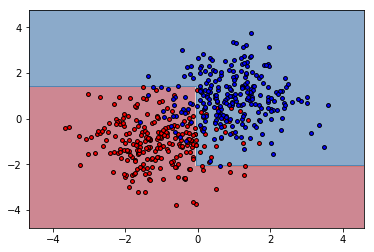

In [21]:
plot_decision_boundaries(tree, X, y)

### 9. And now for something more interesting...
---

How about a toy dataset that is amenable to a somewhat cleaner but still non-linear decision boundary?

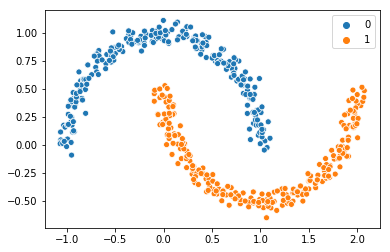

In [22]:
X, y = make_moons(
    n_samples=500,
    noise=0.05,
    random_state=0,
)

sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y);

[<Node 1>] Determining best split...
[<Node 1>] Best split found to be Split(feature=1, value=0.5317001110379349, impurity_before=0.5, impurity_after=0.38302705844024343, num_samples=500)
[<Node 1>] Continuing to split down the left branch to <Node 2>
[<Node 2>] Determining best split...
[<Node 2>] Best split found to be Split(feature=0, value=-0.44935803511672745, impurity_before=0.38302705844024343, impurity_after=0.2504397255646542, num_samples=337)
[<Node 2>] Only one class remains in the left branch, predict 0
[<Node 2>] Continuing to split down the right branch to <Node 3>
[<Node 3>] Determining best split...
[<Node 3>] No splits were found to reduce the Gini impurity
[<Node 1>] Only one class remains in the right branch, predict 0
Decision Tree with 2 node(s) and 3 leaves.
<Node 1> => GOTO <Node 2> IF (FEATURE 1 < 0.532) ELSE PREDICT 0
<Node 2> => PREDICT 0 IF (FEATURE 0 < -0.449) ELSE PREDICT 1


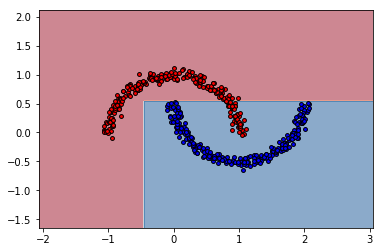

In [23]:
tree = DecisionTree()
tree.fit(X, y, verbose=True)
tree.print()
plot_decision_boundaries(tree, X, y)

The tree doesn't seem to be doing very well on this dataset.

### 10. And now for something even more interesting...
---

Concentric circles should make for the hardest example.

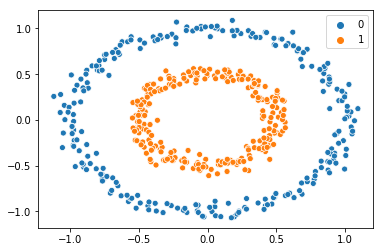

In [24]:
X, y = make_circles(
    n_samples=500,
    noise=0.05,
    factor=0.5,
    random_state=0,
)

sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y);

[<Node 1>] Determining best split...
[<Node 1>] Best split found to be Split(feature=0, value=-0.5492630756195409, impurity_before=0.5, impurity_after=0.48075822439962457, num_samples=500)
[<Node 1>] Only one class remains in the left branch, predict 0
[<Node 1>] Continuing to split down the right branch to <Node 2>
[<Node 2>] Determining best split...
[<Node 2>] Best split found to be Split(feature=0, value=0.5650964176546798, impurity_before=0.48075822439962457, impurity_after=0.38722252677926583, num_samples=418)
[<Node 2>] Continuing to split down the left branch to <Node 3>
[<Node 3>] Determining best split...
[<Node 3>] Best split found to be Split(feature=1, value=-0.7066914139382117, impurity_before=0.38722252677926583, impurity_after=0.2545235781387385, num_samples=339)
[<Node 3>] Only one class remains in the left branch, predict 0
[<Node 3>] Continuing to split down the right branch to <Node 4>
[<Node 4>] Determining best split...
[<Node 4>] Best split found to be Split(feat

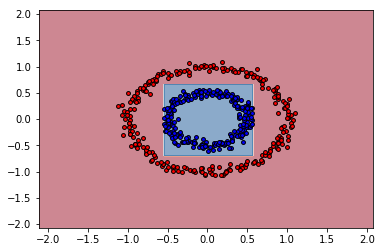

In [25]:
tree = DecisionTree()
tree.fit(X, y, verbose=True)
tree.print()
plot_decision_boundaries(tree, X, y)

In this case, the decision tree was capable of carving out the inner class surrounded by the outer class using only linear decision boundaries.